# PyTorch Lightning Flash
---

> ![FLASH LOGO](https://github.com/PyTorchLightning/lightning-flash/raw/master/docs/source/_static/images/logo.svg)

Flash is a framework of tasks for fast prototyping, baselining, finetuning and solving business and scientific problems with deep learning.
It is focused on:

1. Predictions
1. Finetuning
1. Task-based training


#### Image
- Classification
- Segmentation
- Object Detection
- Style Transfer

#### Text
- Text Classification
- Question Answering

#### Audio
- Classification
- Speech Recognition

#### Tabular
- Classification
- Regression

#### Video
- Classification


In [ ]:
# Install the latest version
!pip install 'git+https://github.com/PyTorchLightning/lightning-flash.git#egg=lightning-flash[image]' -q

In [2]:
import torch
import flash
from flash.image import SemanticSegmentationData
from flash.image import SemanticSegmentation
from flash.core.data.utils import download_data

## Image Classification Training with Pure PyTorch

It is a multistep process-

1. Load Dataset
2. Build Model
3. Create Loss function and Optimizer
4. Train Model

In [3]:
# source: PyTorch.org - TRAINING A CLASSIFIER 

import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4


In [5]:
trainset = torchvision.datasets.CIFAR10(root='~/data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='~/data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/data/cifar-10-python.tar.gz to /root/data
Files already downloaded and verified


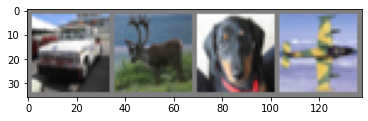

truck  deer   dog plane


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [15]:
DEVICE = "cuda"

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net = net.to(DEVICE)
optimizer = torch.optim.Adam(net.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.cpu().item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

## With Flash

In [19]:
import torch

import flash
from flash.core.data.utils import download_data
from flash.image import ImageClassificationData, ImageClassifier

In [ ]:
datamodule = ImageClassificationData.from_folders(
    train_folder="~/data/cifar10/train",
    val_folder="~/data/cifar10/val",
)

In [ ]:
model = ImageClassifier(backbone="resnet18", num_classes=datamodule.num_classes)

trainer = flash.Trainer(max_epochs=3, gpus=torch.cuda.device_count())
trainer.finetune(model, datamodule=datamodule, strategy="freeze")

## Flash Zero

Flash Zero is a zero-code machine learning platform. Here’s an image classification example to illustrate with one of the dozens tasks available.


In [ ]:
!flash image_classification \
    --trainer.max_epochs 10 \
    --model.backbone resnet50 \
  from_folders \
    --train_folder data/hymenoptera_data/train

## Training Semantic Segmentation and My Contribution

In [ ]:
# download_data(
#     "https://github.com/ongchinkiat/LyftPerceptionChallenge/releases/download/v0.1/carla-capture-20180513A.zip",
#     "./data",
# )

In [ ]:
dm = SemanticSegmentationData.from_folders(
    train_folder="data/CameraRGB",
    train_target_folder="data/CameraSeg",
    val_split=0.1,
    image_size=(256, 256),
    num_classes=21,
)

In [ ]:
model = SemanticSegmentation(
  head="fpn", backbone='efficientnet-b0', pretrained="advprop", num_classes=dm.num_classes)

In [ ]:
# # 3. Create the trainer and finetune the model
# trainer = flash.Trainer(max_epochs=3, gpus=torch.cuda.device_count())
# trainer.finetune(model, datamodule=dm, strategy="freeze")

In [ ]:
# 4. Segment a few images!
predictions = model.predict(
    [
        "data/CameraRGB/F61-1.png",
        "data/CameraRGB/F62-1.png",
        "data/CameraRGB/F63-1.png",
    ]
)
print(predictions)

In [ ]:
# !flash semantic_segmentation --help